# Titanic Classifier

The goal of this project is to find and train a classifier model to make successful predictions on the *Titanic* dataset, guessing whether a passenger survived the accident or not. The features associated to each passenger comprehend various aspects such as age, sex, passenger class, embarking location and so on.

### Data fetching

In [5]:
import os
import urllib.request

import numpy as np

TITANIC_PATH = os.path.join("datasets", "titanic")
DOWNLOAD_URL = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/titanic/"

def fetch_titanic_data(url=DOWNLOAD_URL, path=TITANIC_PATH):
    if not os.path.isdir(path):
        os.makedirs(path)
    for filename in ("train.csv", "test.csv"):
        filepath = os.path.join(path, filename)
        if not os.path.isfile(filepath):
            print("Downloading", filename)
            urllib.request.urlretrieve(url + filename, filepath)

fetch_titanic_data()

In [6]:
# we need pandas to store the data:
import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [7]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

__Attention__: the `test_data` does not contain the labels. To compare our results with actual ones we can upload them to Kaggle and look for our score.

In [8]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


First of all, we notice that the *survived* feature is actually our target label. Furthermore, we could use the *passenger ID* as the index:

In [9]:
train_data.set_index('PassengerId', inplace=True)
test_data.set_index('PassengerId', inplace=True)

In [10]:
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


As you can see, the *cabin* attribute is lacking a lot of values and so it will be discarded - maybe later we'll try to adjust it.
The *age* and *embarked* attributes are also missing some values. However, we could use a simple imputer to fill these values. Let's check these data:

In [12]:
train_data['Age'].mean()

29.699113025210085

In [13]:
print('Mean males age:\t\t', train_data[train_data['Sex']=='male']['Age'].mean())
print('Mean females age:\t', train_data[train_data['Sex']=='female']['Age'].mean())

Mean males age:		 30.726637306843266
Mean females age:	 27.915708812260537


The mean values could be quite a reasonable substitution for the missing ages.

In [14]:
train_data['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

For the *embarked* attribute, the 'most frequent' (or *mode*) substitution could be a good idea. An even better option would be to try to respect the proportions of the 3 classes.

In [15]:
# defining the numerical pipeline:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [16]:
# defining the categorical pipeline:
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('cat_encoder', OneHotEncoder(sparse=False))
])

It is now time to process the data using the pipelines that we have just defined. By now, we exclude the *name* and *ticket* attributes since we think that they probably don't deal with the surviving probability; we exclude also the *cabin* attribute since the high number of missing values:

In [17]:
train_data.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [18]:
from sklearn.compose import ColumnTransformer

num_attribs = ['Age', 'SibSp', 'Parch', 'Fare']
cat_attribs = ['Pclass', 'Sex', 'Embarked']

preprocess_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs)
])

X_train = preprocess_pipeline.fit_transform(
    train_data[num_attribs + cat_attribs]
)

In [19]:
X_train[:5]

array([[-0.56573582,  0.43279337, -0.47367361, -0.50244517,  0.        ,
         0.        ,  1.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  1.        ],
       [ 0.6638609 ,  0.43279337, -0.47367361,  0.78684529,  1.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  1.        ,
         0.        ,  0.        ],
       [-0.25833664, -0.4745452 , -0.47367361, -0.48885426,  0.        ,
         0.        ,  1.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  1.        ],
       [ 0.43331151,  0.43279337, -0.47367361,  0.42073024,  1.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  1.        ],
       [ 0.43331151, -0.4745452 , -0.47367361, -0.48633742,  0.        ,
         0.        ,  1.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  1.        ]])

In [20]:
# take the labels array:
y_train = train_data['Survived']

y_train[:5]

PassengerId
1    0
2    1
3    1
4    1
5    0
Name: Survived, dtype: int64

#### Stochastic gradient descent:

In [21]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss='squared_error', eta0=0.01, learning_rate='constant')

In [22]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(eta0=0.01, learning_rate='constant', loss='squared_error')

In [23]:
from sklearn.model_selection import cross_val_score

sgd_score = cross_val_score(sgd_clf, X_train, y_train, cv=10)
sgd_score.mean()

0.8002122347066167

Not bad at all, let's try to insert a regularization term:

In [24]:
sgd_clf = SGDClassifier(loss='squared_error', eta0=0.01, learning_rate='constant', penalty='l2')

In [25]:
sgd_clf.fit(X_train, y_train)
sgd_score = cross_val_score(sgd_clf, X_train, y_train, cv=10)
sgd_score.mean()

0.7878651685393258

Very similar result but a bit weaker. Now let's try to visualize the performance based on the value of $\eta_0$.

In [26]:
eta0_val = np.logspace(-5,1,100)
scores = []

for eta in eta0_val:
    sgd_clf = SGDClassifier(loss='squared_error', eta0=eta, learning_rate='constant', penalty='l2')

    sgd_clf.fit(X_train, y_train)
    sgd_score = cross_val_score(sgd_clf, X_train, y_train, cv=10)

    scores = np.append(scores, sgd_score.mean())

Text(0, 0.5, 'Cross Validation Accuracy (cv=10)')

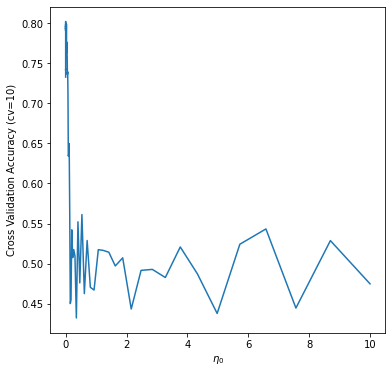

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.plot(eta0_val, scores)
plt.xlabel('$\eta_0$')
plt.ylabel('Cross Validation Accuracy (cv=10)')

In [28]:
scores.max()

0.8024719101123594

In [29]:
sgd_clf = SGDClassifier(loss='squared_error', eta0=eta0_val[scores.argmax()], learning_rate='constant', penalty='l2')

sgd_clf.fit(X_train, y_train)
sgd_score = cross_val_score(sgd_clf, X_train, y_train, cv=10)

sgd_score.mean()

0.8024719101123594

So  very little $\eta_0$ performs better. Try the same with *optimal* learning rate:

Text(0, 0.5, 'Cross Validation Accuracy (cv=10)')

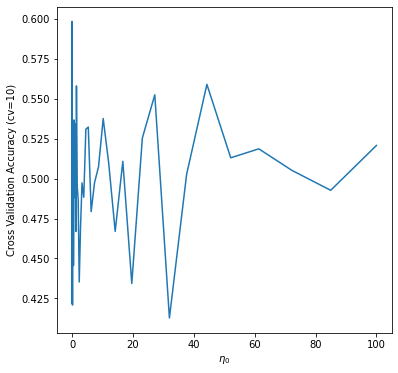

In [30]:
eta0_val = np.logspace(-5, 2, 100)
scores = []

for eta in eta0_val:
    sgd_clf = SGDClassifier(loss='squared_error', eta0=eta, learning_rate='optimal', penalty='l2')

    sgd_clf.fit(X_train, y_train)
    sgd_score = cross_val_score(sgd_clf, X_train, y_train, cv=10)

    scores = np.append(scores, sgd_score.mean())
import matplotlib.pyplot as plt


plt.figure(figsize=(6, 6))
plt.plot(eta0_val, scores)
plt.xlabel('$\eta_0$')
plt.ylabel('Cross Validation Accuracy (cv=10)')

At last, try with *adaptive*:

Text(0, 0.5, 'Cross Validation Accuracy (cv=10)')

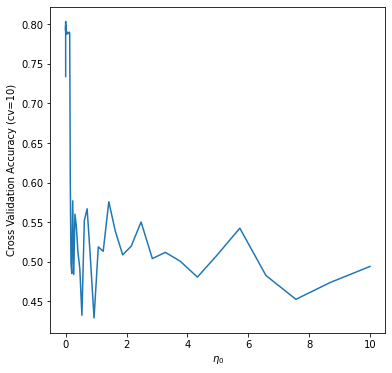

In [31]:
eta0_val = np.logspace(-5, 1, 100)
scores = []

for eta in eta0_val:
    sgd_clf = SGDClassifier(loss='squared_error', eta0=eta, learning_rate='adaptive', penalty='l2')

    sgd_clf.fit(X_train, y_train)
    sgd_score = cross_val_score(sgd_clf, X_train, y_train, cv=10)

    scores = np.append(scores, sgd_score.mean())
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.plot(eta0_val, scores)
plt.xlabel('$\eta_0$')
plt.ylabel('Cross Validation Accuracy (cv=10)')

In [32]:
scores.max()

0.8035830212234707

The simple SGD performed very well with a sufficiently small $\eta_0$!

#### Random Forest Classifier:

In [33]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [34]:
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8137578027465668

This method performed even better than the SGD. Let's try the last one:

__SVM__:

In [35]:
from sklearn.svm import SVC

svc_clf = SVC(gamma='auto')
svc_clf.fit(X_train, y_train)
svc_scores = cross_val_score(svc_clf, X_train, y_train, cv=10)

svc_scores.mean()

0.8249313358302123

The performance from the SVM seems to be better but very similar to the one made by the *Random Forest* classifier. How to decide between the 2 models? In this case, we could try to compare the performance's sensitivity to outliers, to understand which one generalizes better. We then plot a representation:

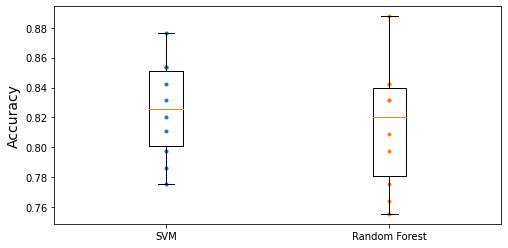

In [36]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svc_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svc_scores, forest_scores], labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

* the higher and lower line represent the higher and lower score;
* the central line represents the mean score value;
* the height of the box is determined by a lower and upper quartile. Every point outside the box is considered an *outlier*, meaning that it's not well representative of the mean value.

The plot is quite clear: the random forest model produced a high mean value, but the box contains only 3 out of 10 scores. Furthermore, the mean line is in the upper part of the box, meaning that we're probably overestimating its value since it's highly influenced by a single great score value (above 88%).
Then we should use the SVM classifier to evaluates our predictions to submit to Kaggle!

In [37]:
X_test = preprocess_pipeline.fit_transform(
    test_data[num_attribs + cat_attribs]
)

In [38]:
test_data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [39]:
predictions = pd.DataFrame(svc_clf.predict(X_test))
predictions.head()

,0
0,0
1,1
2,0
3,0
4,1


In [40]:
predictions.set_index(test_data.index, inplace=True)
predictions.columns = ['Survived']

predictions.head()

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1


In [41]:
predictions.to_csv(f'{TITANIC_PATH}/predictions.csv')